In [1]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [2]:
timeseries = data[["Passengers"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [3]:
import torch
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([92, 4, 1]) torch.Size([92, 4, 1])
torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


/tmp/ipykernel_65867/889363884.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X), torch.tensor(y)


In [4]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        # shape (batch, lookback, feature)
        # shape (batch, batch_size, hidden_size)
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
train_data = TensorDataset(X_train, y_train)
loader = DataLoader(train_data, shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    # if epoch % 100 != 0:
    #     continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.5849, test RMSE 424.8037
Epoch 1: train RMSE 225.3075, test RMSE 424.5080
Epoch 2: train RMSE 225.0905, test RMSE 424.2848
Epoch 3: train RMSE 224.8969, test RMSE 424.1188
Epoch 4: train RMSE 224.5189, test RMSE 423.7932
Epoch 5: train RMSE 223.9608, test RMSE 423.1531
Epoch 6: train RMSE 222.9839, test RMSE 422.2651
Epoch 7: train RMSE 221.8508, test RMSE 420.9880
Epoch 8: train RMSE 220.8606, test RMSE 420.0100
Epoch 9: train RMSE 220.1165, test RMSE 419.1409
Epoch 10: train RMSE 219.5226, test RMSE 418.5266
Epoch 11: train RMSE 218.9244, test RMSE 417.9063
Epoch 12: train RMSE 218.2252, test RMSE 417.1993
Epoch 13: train RMSE 217.6419, test RMSE 416.5584
Epoch 14: train RMSE 217.1087, test RMSE 416.0203
Epoch 15: train RMSE 216.5175, test RMSE 415.4211
Epoch 16: train RMSE 215.9004, test RMSE 414.7464
Epoch 17: train RMSE 215.3815, test RMSE 414.2108
Epoch 18: train RMSE 214.8794, test RMSE 413.6992
Epoch 19: train RMSE 214.2725, test RMSE 413.0716
Epoch 20: 

torch.Size([92, 1])


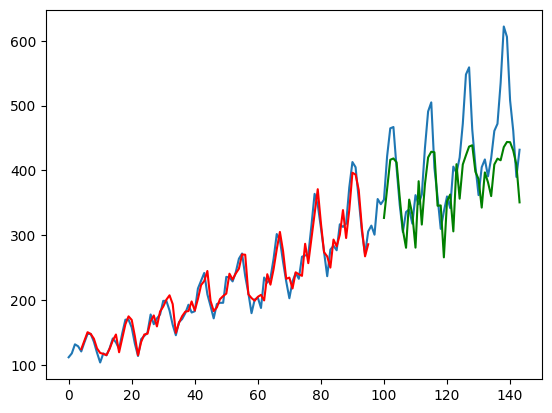

In [6]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    print(y_pred.shape)
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()